In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [3]:
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
start = pd.Timestamp('2023-05-23 13:00:00.000000')
now = pd.Timestamp.utcnow()
start,now

(Timestamp('2023-05-23 13:00:00'),
 Timestamp('2023-05-23 13:16:54.934044+0000', tz='UTC'))

In [6]:
filter_ = 'resource.labels.cluster_name="midori" AND ' + \
           'jsonPayload.method="submitNewBlockV2" AND ' + \
           '"optimistically parsed bid and verified signature" ' + \
           'AND timestamp>=' + '\"' + (start).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
           'AND timestamp<=' + '\"' + (now).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'
filter_

'resource.labels.cluster_name="midori" AND jsonPayload.method="submitNewBlockV2" AND "optimistically parsed bid and verified signature" AND timestamp>="2023-05-23T13:00:00.000000Z" AND timestamp<="2023-05-23T13:16:54.934044Z"'

In [7]:
res = []
subs = pd.DataFrame(columns=['slot', 'decode_dur', 'content_length'])
for e in client.list_entries(filter_=filter_):
    res.append((e.payload['decode_time'], e.payload['contentLength']))
res = np.asarray(res)
res.shape

(2294, 2)

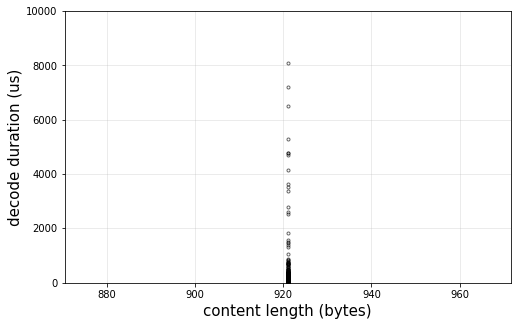

In [8]:
f, ax = plt.subplots(figsize=(8,5))

ax.plot(res[:,1], res[:,0], 'k.', fillstyle='none', alpha=0.6)

ax.set_ylim(-10, 10000)
ax.set_xlabel('content length (bytes)', size=15)
ax.set_ylabel('decode duration (us)', size=15)
plt.show()

In [9]:
durs = res[:,0]
durs[durs<10000]

array([ 37.,  41.,  36., ...,  57.,  44., 105.])

In [10]:
len(durs), len(durs[durs<10000])

(2294, 2232)

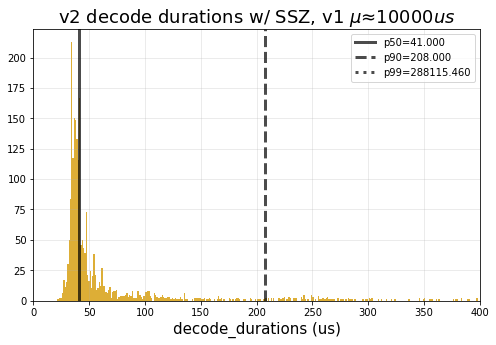

In [23]:
f, ax = plt.subplots(figsize=(8,5))

ax.hist(durs[durs<500], color='goldenrod', alpha=0.9, bins=400)

percs = [(int(i*100), np.quantile(durs, i)) for i in [.50, .90, .99]]
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)
# ax.axvline(durs.mean(), label='$\mu$={:0.3f}'.format(durs[durs<10000].mean()), color='mediumpurple', linewidth=3, alpha=0.7)

ax.legend(loc=1)
ax.set_xlabel('decode_durations (us)', size=15)
ax.set_title('v2 decode durations w/ SSZ, v1 $\mu ≈ 10000us$')
# ax.set_ylim(-10, 10000)
ax.set_xlim(0, 400)
plt.show()

In [37]:
res[:,0].per()

7831.44

In [14]:
durs

array([ 37.,  41.,  36., ...,  57.,  44., 105.])

In [16]:
st = ""
for i in [50, 75, 90, 99]:
    st += str(int(np.percentile(durs, i)))
    st += " & "
st

'41 & 61 & 208 & 288115 & '

In [2]:
june15 = pd.read_csv('june15-logs.csv')
june15.head()

,insertId,jsonPayload.level,jsonPayload.method,jsonPayload.msg,jsonPayload.service,jsonPayload.timeSinceEligibleAt,jsonPayload.timeSinceReceivedAt,jsonPayload.timestampEligible,jsonPayload.timestampExecutionPayloadSaved,jsonPayload.timestampRequestStarted,...,receiveTimestamp,resource.labels.cluster_name,resource.labels.container_name,resource.labels.location,resource.labels.namespace_name,resource.labels.pod_name,resource.labels.project_id,resource.type,severity,timestamp
0,vci78i9h63bnl9tq,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,17152,35529,1686834036524,1686834036543,1686834036560,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:36Z
1,bc7trrtsgmniz09g,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,76285,179717,1686834036095,1686834036199,1686834036275,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:36Z
2,9r7ffgqj10n0tq28,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,53222,63424,1686834036501,1686834036511,1686834036564,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:36Z
3,6e58kge6r30yps4i,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,74890,81612,1686834035931,1686834035938,1686834036012,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:36Z
4,cnz9zrxjcq9xi392,info,optimisticV2SlowPath,v2 execution payload saved,relay/api,4953,7261,1686834035165,1686834035167,1686834035172,...,2023-06-15T13:00:37.689148205Z,midori,builder-api,europe-west1-b,default,builder-api-7888d47c4c-cn7s2,ultra-sound-relay,k8s_container,INFO,2023-06-15T13:00:35Z


In [12]:
elig = june15['jsonPayload.timeSinceEligibleAt'].values
recv = june15['jsonPayload.timeSinceReceivedAt'].values

Text(0.5, 1.0, 'time to save payload')

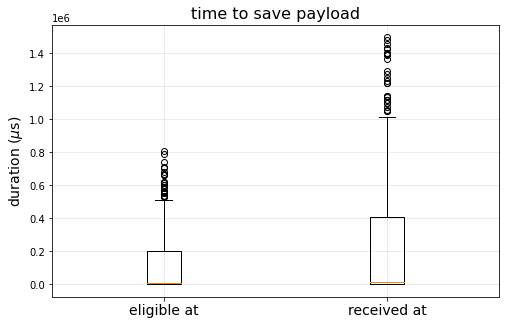

In [21]:
f, ax = plt.subplots(figsize=(8,5))
ax.boxplot([elig, recv])
ax.set_xticklabels(['eligible at', 'received at'], size=14)
ax.set_ylabel('duration ($\mu$s)', size=14)
ax.set_title('time to save payload', size=16)

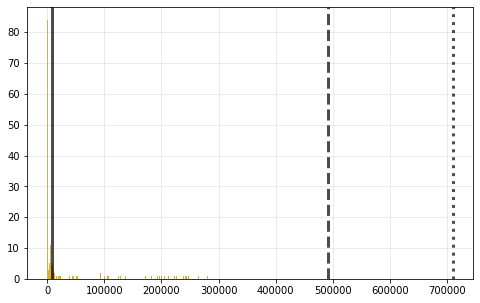

In [10]:
f, ax = plt.subplots(figsize=(8,5))

ax.hist(elig[elig<300000], color='goldenrod', alpha=0.9, bins=400)

percs = [(int(i*100), np.quantile(elig, i)) for i in [.50, .90, .99]]
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.3f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

# ax.legend(loc=1)
# ax.set_xlabel('decode_durations (us)', size=15)
# ax.set_title('v2 decode durations w/ SSZ, v1 $\mu ≈ 10000us$')
# # ax.set_ylim(-10, 10000)
# ax.set_xlim(0, 400)
plt.show()